# <span style="color:lightblue">PREDICTING BANK PRODUCT SUBSCRIPTION</span>

Authors:

- Miguel Ramos Cabañas 100473854

- Miguel Rodríguez Losada 100568756

##  <span style="color:#0066CC">Libraries Import</span>

Before starting the analysis, we first import all the libraries we’ll need throughout the assignment.
These include basic tools for working with data (like pandas and numpy), plotting (matplotlib), and building machine-learning models (scikit-learn).
Having all the imports together at the beginning keeps the notebook organized and makes it easier to see which tools we are using.

In [1]:
import time
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from statsmodels.stats.proportion import proportion_confint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer

##  <span style="color:#0066CC"> Data Import</span>

We use the last 2 digits from the NIA from the first author. As a consequence, we select the data folder **bank_54**.

For convenience and ease of manipulation, the data are loaded into a pandas DataFrame.


In [2]:
data = pd.read_pickle("P1_assignment_dataset_bank_ALL/bank_54.pkl")

print(data.head())

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  


##  <span style="color:#0066CC"> Simplified EDA</span>

Before exploring the data, it is useful to understand what each variable represents.
The table below summarizes all the columns in the dataset, including client information, campaign details, and the target variable deposit.

| Variable | Short Description |
| :--- | :--- |
| **age** | age in years |
| **job** | type of job |
| **marital** | marital status |
| **education** | education level |
| **default** | has credit in default? |
| **balance** | average yearly balance |
| **housing** | has a housing loan? |
| **loan** | has a personal loan? |
| **contact** | contact communication type |
| **day_of_week** | last contact day |
| **month** | last contact month |
| **duration** | last contact duration, in seconds |
| **campaign** | number of contacts performed during this campaign and for this client |
| **pdays** | number of days that passed by after the client was last contacted from a previous campaign. The value is -1 if no/unknown contact was produced. |
| **previous** | number of contacts performed before this campaign and for this client |
| **poutcome** | outcome of the previous marketing campaign |
| **deposit** | has the client subscribed a term deposit? **TARGET VARIABLE** |

To begin the exploratory analysis, we first determine the size of the dataset by identifying the total number of instances (rows) and features (columns).

In [3]:
print("The number of instances (rows) in the dataset is", len(data), "and the number of features (columns) is", len(data.columns))

The number of instances (rows) in the dataset is 11000 and the number of features (columns) is 17


Also, it is important to understand the type of each variable in the dataset.  
This helps us decide how to handle them later: for example, numerical features may require scaling, while categorical features need encoding.  

In the following step, we separate the variables into two groups:
- **Numerical variables** (integers or floats) 
- **Categorical variables** (strings or objects)

In [4]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object','category']).columns.tolist()

print("Numerical variables:", numerical_cols)
print("Categorical variables:", categorical_cols)

Numerical variables: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


In the following step, we compute the number of unique values for each categorical feature to detect potential high-cardinality columns.

In [5]:
unique_counts = {col: data[col].nunique() for col in categorical_cols}

print("Number of unique categories per categorical variable:")
for col, count in unique_counts.items():
    print(f"{col}: {count}")

Number of unique categories per categorical variable:
job: 12
marital: 3
education: 4
default: 2
housing: 2
loan: 2
contact: 3
month: 12
poutcome: 4
deposit: 2


We next examine the presence of missing values and identify any features that may need special treatment.  
Specifically, we check:
- whether any variables contain missing entries,
- whether any columns are constant (i.e., have only one unique value), and
- whether any column behaves like an identifier, containing a different value for every row.


In [6]:
missing_values = data.isna().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
age            0
job            0
marital      538
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
deposit        0
dtype: int64


In addition to checking for missing values, it is important to compute the occurrences of "unknown" because several categorical variables use this label to represent missing information, which is not captured by standard NaN checks and could otherwise bias the preprocessing and model training stages.

In [7]:
unknown_counts = (data[categorical_cols] == "unknown").sum()

print("Number of 'unknown' entries per categorical variable:")
print(unknown_counts)

Number of 'unknown' entries per categorical variable:
job            68
marital         0
education     494
default         0
housing         0
loan            0
contact      2309
month           0
poutcome     8205
deposit         0
dtype: int64


In [8]:
constant_cols = [col for col in data.columns if data[col].nunique() == 1]
print("\nConstant columns:")
print(constant_cols)


Constant columns:
[]


In [9]:
id_like_cols = [col for col in data.columns if data[col].nunique() == len(data)]
print("\nID-like columns:")
print(id_like_cols)


ID-like columns:
[]


During the simplified exploratory analysis, we observed that the variable **`marital`** contains 538 missing entries. Since this feature is categorical and represents the marital status of each client, we address the missingness by applying a *SimpleImputer* with `strategy = 'most_frequent'`, which replaces missing values with the most common category observed in the data.

This imputation is performed **before** the train/test split. This choice is justified because:

- The imputation rule does not use any information from the target variable, meaning that no leakage occurs from the labels.
- The imputer relies exclusively on the distribution of the **`marital`**  feature itself, which is safe to compute on the full dataset and does not bias the later evaluation.
- Performing imputation before splitting avoids inconsistencies where different partitions may learn different replacement values.

In [10]:
# First, compute the most frequent category
most_frequent_category = data['marital'].mode()[0]
print(f"The most frequent category in 'marital' is: {most_frequent_category}")

# Replace None values safely
data['marital'] = data['marital'].fillna(most_frequent_category)

print("\nMissing values after imputation (NaN count):")
print(data['marital'].isna().sum())

The most frequent category in 'marital' is: married

Missing values after imputation (NaN count):
0


In addition to standard missing values, several categorical variables use the label “unknown” to represent missing or unspecified information.
These values are not detected by the usual NaN checks and therefore require special attention.
Notably, variables such as **`education`**, **`contact`**, and especially **`poutcome`** contain a large number of "unknown" entries, which may influence the preprocessing choices (e.g., treating "unknown" as its own category or performing imputation).

We also checked for constant columns, and none were found.
This is positive, as it indicates that every feature contributes some variability to the dataset.

Finally, there are no ID-like columns, meaning the dataset does not include fields that uniquely identify each row.
This confirms that all variables are potentially useful for modelling and that no column needs to be removed for behaving like an identifier.

After this initial inspection of the dataset, we can verify that the task corresponds to a **binary classification problem**, where the **target variable** **`deposit`** takes two possible values: yes or no.

The objective is to predict whether a client has subscribed to a term deposit based on the available features.

To verify whether the classification problem is imbalanced, we examine the class proportions of the target variable deposit.

This will be a key point to determine the strategy for the outer and inner evaluation.


In [11]:
data['deposit'].value_counts(normalize=True)


deposit
no     0.525455
yes    0.474545
Name: proportion, dtype: float64

The target variable shows a proportion of approximately 52.5% for "no" and 47.5% for "yes".  
This distribution is relatively balanced, meaning we do not need any special imbalanced-learning techniques.  

The variable **`pdays`** indicates the number of days since the client was last contacted in a previous campaign.  
A value of **–1** means the client was never contacted.  

In [12]:
print(data['pdays'].describe())

count    11000.000000
mean        51.308636
std        108.782842
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         20.250000
max        854.000000
Name: pdays, dtype: float64



Most values are –1, meaning the variable is highly skewed and not suitable as a standard numerical feature.  

A good strategy to simplify its interpretation, would be create a new categorical variable:

- False → client was previously contacted  
- True → client was never contacted

This captures the relevant information without misinterpreting –1 as a real day count.

In [13]:
# Binary transformation of pdays
data['pdays_contacted'] = (data['pdays'] != -1).astype('category')

# Quick check
data['pdays_contacted'].value_counts()

pdays_contacted
False    8203
True     2797
Name: count, dtype: int64

After creating the categorical variable **`pdays_contacted`**, we also need to prepare the original **`pdays`** column for use as a numerical feature. Since the value `-1` indicates that the client has never been contacted, it is not a valid numeric distance for modeling purposes.  

To ensure that **`pdays`** behaves as a consistent numerical variable, we replace `-1` with `0`, keeping the same variable name. This transformation preserves all meaningful positive day counts while preventing the presence of an artificial negative value that could distort scaling or distance-based algorithms.

In [14]:
data["pdays"] = data["pdays"].replace(-1, 0)
print(data['pdays'].describe())

count    11000.000000
mean        52.054364
std        108.424506
min          0.000000
25%          0.000000
50%          0.000000
75%         20.250000
max        854.000000
Name: pdays, dtype: float64


In [15]:
# Just checking all the variables in our data
print(data.columns.tolist())

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'pdays_contacted']


**Note:**  The variables **`day_of_week`** and **`month`** could be preprocessed in several ways, such as encoding them jointly, applying cyclical transformations, or deriving new temporal features that capture seasonal patterns. Each of these approaches has potential advantages and disadvantages.  In this exploratory stage, we deliberately keep both variables in their original categorical form. This decision preserves potentially meaningful behavioural signals, for example, differences in subscription patterns between clients contacted at the beginning versus the end of a month.  


##  <span style="color:#0066CC"> Definition of the outer and inner evaluation</span>

###  <span style="color:#0066CC"> Definition of the outer evaluation</span>

Before training any predictive model, we first need to define the evaluation strategy that will be used to estimate its performance. According to the assignment guidelines, the chosen evaluation method must be **Houldout**, therefore we must decide what proportion of the data will be allocated to the training and test partitions.

To make this decision in a principled way, we analyze several possible test sizes and examine how they affect both the estimated accuracy and the uncertainty of that estimate, expressed through 95% Clopper–Pearson confidence intervals. This approach follows the methodology discussed in Topic 3: Model Evaluation, where the width of the confidence interval is used as a measure of the reliability of the performance estimate.

Therefore, we evaluate multiple test sizes (5%, 10%, 15%, 20%, 25%, 30%), compute the corresponding accuracy and confidence intervals using a simple decision tree as a proxy model, summarize the results in a table, and finally visualize how both uncertainty and accuracy vary with the test size.


In [16]:
# 1. ANALYSIS FUNCTION 
def analyze_test_accuracy(data, target_col, test_sizes=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    """
    We analyze the effect of different test sizes on accuracy estimates using a decision tree.
    We return a DataFrame including estimated accuracy, Clopper-Pearson confidence intervals, and their widths.
    Note: This methology was extracted from the notion of Binomial/Beta distribution in Topic 3 for selecting optimal test size.
    """
    
    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]


    # Identify categorical columns and apply OneHotEncoder
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    # Transform features
    X_array = preprocessor.fit_transform(X)

    # Attempt to retrieve feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except:
        feature_names = [f"feat_{i}" for i in range(X_array.shape[1])]

    # Create DataFrame with transformed features
    X = pd.DataFrame(X_array, columns=feature_names)

    # For Each Test Size: Train/Test Split, Fit Model, Compute Accuracy and CI
    results = []
    for test_size in test_sizes:
        
        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=100473854
        )

        # Fit a decision tree as a proxy model
        clf = DecisionTreeClassifier(random_state=100473854, max_depth=5)
        clf.fit(X_train, y_train)

        # Compute accuracy
        y_pred = clf.predict(X_test)
        n_test = len(y_test)
        correct_predictions = np.sum(y_pred == y_test)
        accuracy = correct_predictions / n_test

        # Compute Clopper-Pearson (Beta) confidence interval
        ci_low, ci_high = proportion_confint(correct_predictions, n_test, alpha=0.05, method='beta')
        width = ci_high - ci_low

        # We store exact numerical values to ensure plotting accuracy
        results.append({
            'Test Size %': int(test_size*100),
            'N Test': n_test,
            'N Train': len(y_train),
            'Accuracy Est.': accuracy,
            'CI Low': ci_low,
            'CI High': ci_high,
            'CI Width': width
        })

    return pd.DataFrame(results)


In [17]:
# 2. PLOTTING FUNCTION
def plot_results(df, optimal_pct=15):
    """
    We visualize the accuracy estimates and confidence intervals obtained for different test sizes.
    The first plot shows uncertainty vs. test size; the second shows error bars for estimated accuracy.
    """

    # Prepare the figures layout
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # PLOT 1: Uncertainty Curve: x-axis = test size (%), y-axis = CI width
    sizes = df['Test Size %']
    widths = df['CI Width']
    ax1.plot(sizes, widths, marker='o', linestyle='-', color='gray', label='Interval Width')

    ## Highlight the optimal test size
    row_opt = df[df['Test Size %'] == optimal_pct]
    if not row_opt.empty:
        val_width = row_opt['CI Width'].values[0]
        ax1.scatter(optimal_pct, val_width, color='red', s=150, zorder=5, label=f'Selection ({optimal_pct}%)')
        ax1.axvline(x=optimal_pct, color='red', linestyle='--', alpha=0.5)
        ax1.annotate(f'Width: {val_width:.4f}',
                     xy=(optimal_pct, val_width), xytext=(optimal_pct+2, val_width+0.01),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    ## Labels and legend
    ax1.set_title('Uncertainty vs. Test Size\n(Smaller Width is Better)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Test Size (%)')
    ax1.set_ylabel('Interval Width')
    ax1.legend()

    # PLOT 2: Error Bars for Accuracy
    y_err_low = df['Accuracy Est.'] - df['CI Low']
    y_err_high = df['CI High'] - df['Accuracy Est.']
    error_bars = [y_err_low, y_err_high]
    colors = ['red' if s == optimal_pct else 'skyblue' for s in sizes]

    ax2.errorbar(sizes, df['Accuracy Est.'], yerr=error_bars, fmt='none', ecolor='gray', elinewidth=2, capsize=5)
    ax2.scatter(sizes, df['Accuracy Est.'], s=100, c=colors, zorder=3)

    ## Title and labels
    ax2.set_title('Statistical Accuracy (Real Confidence Intervals)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Test Size (%)')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


Results Table:
 Test Size %  N Test  N Train  Accuracy Est.      CI 95% Text  CI Width
           5     550    10450       0.789091 [0.7526, 0.8225]  0.069887
          10    1100     9900       0.790000 [0.7647, 0.8137]  0.049008
          15    1650     9350       0.796970 [0.7767, 0.8161]  0.039403
          20    2200     8800       0.802727 [0.7855, 0.8192]  0.033698
          25    2750     8250       0.813091 [0.7980, 0.8275]  0.029495
          30    3300     7700       0.810000 [0.7962, 0.8233]  0.027066

Generating plots...


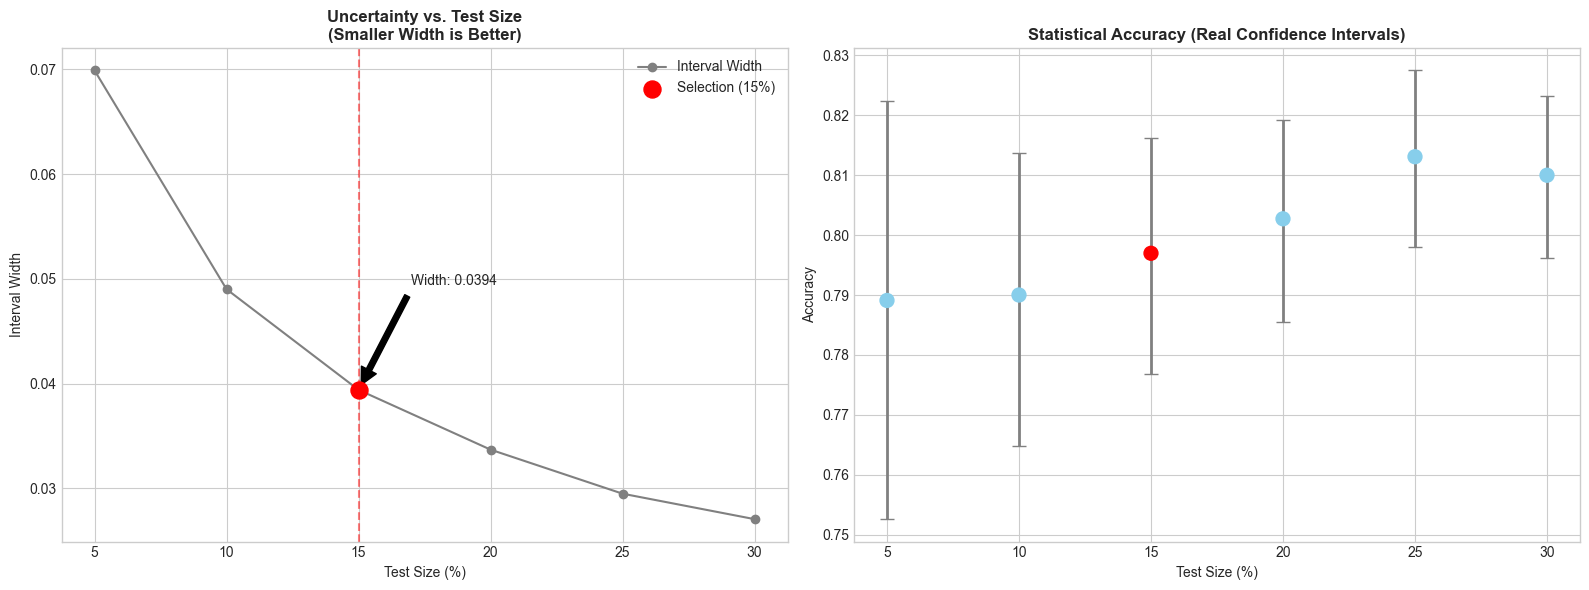

In [18]:
# 3. MAIN EXECUTION
try:
    # Run analysis function
    df_res = analyze_test_accuracy(data, "deposit")  

    # Print results table
    print("Results Table:")
    print_df = df_res.copy()
    print_df['CI 95% Text'] = print_df.apply(lambda x: f"[{x['CI Low']:.4f}, {x['CI High']:.4f}]", axis=1)
    cols_show = ['Test Size %', 'N Test', 'N Train', 'Accuracy Est.', 'CI 95% Text', 'CI Width']
    print(print_df[cols_show].to_string(index=False))

    # Generate plots
    print("\nGenerating plots...")
    plot_results(df_res, optimal_pct=15)

except NameError:
    print("Error: Please ensure the variable 'data' is loaded before running.")
except Exception as e:
    print(f"An error occurred: {e}")

In the left plot, we evaluate the width of the 95% Clopper–Pearson confidence interval for several test sizes. A smaller interval width indicates a more precise estimate of the model’s accuracy. We observe a rapid decrease in uncertainty when increasing the test size from 5% to 15%, after which the reduction becomes more gradual. At a test size of **15%**, the interval width reaches approximately **0.039**, which represents an effective balance between precision and the amount of data preserved for training.

The right plot shows the estimated accuracy for each test size, along with its corresponding confidence intervals. The accuracy remains relatively stable across all configurations (approximately 0.79–0.81), meaning that accuracy alone does not strongly favor one test size over another. However, the 15% test split provides a good compromise, offering a reliable estimate while keeping 85% of the data available for model training.

Based on this analysis, we select a **15% test size** as the evaluation strategy for the assignment.

Based on the previous analysis, we now split the dataset using the selected proportions: 85% for training and 15% for testing.

In [19]:
# Final Train/Test Split with Optimal Test Size

X = data.drop(columns='deposit') 
y = data['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15,  
    random_state=100473854, 
    stratify=y       
)

print("Size X_train:", X_train.shape)
print("Size X_test:", X_test.shape)

Size X_train: (9350, 17)
Size X_test: (1650, 17)


In [20]:
# Just checking all the variables in our data
print(data.columns.tolist())

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'pdays_contacted']


###  <span style="color:#0066CC"> Definition of the inner evaluation</span>

Once the outer evaluation has been defined (Holdout with an 85%/15% split), the next step is to decide how the **inner evaluation** will be carried out.  
The inner evaluation is essential for:

- performing **hyper-parameter optimization (HPO)**, and  
- comparing different model alternatives as part of the **CASH problem**  
  (Combined Algorithm Selection and Hyper-parameter optimization).

According to the lecture notes (Lesson 4: HPO), the inner evaluation must provide **reliable performance estimates** while keeping the computational cost manageable.  
To make an informed decision, we evaluate different configurations of **K-fold Cross-Validation**, varying the number of folds from **3 to 10**.

To select the most appropriate CV scheme, we follow this procedure:

1. **Use a simple baseline model (Default Decision Tree)**
   - Trees are computationally lightweight and are the base estimator of bagging/boosting methods.
   - This makes them ideal for comparing CV configurations without long execution times.

2. **For each value of K ∈ {3, 4, …, 10}:**
   - Compute some metrics, such as the **mean validation accuracy**.
   - Measure the **execution time**
   - Store the results for comparison

3. **Analyze the trade-off between accuracy and computation**
   - Increasing K reduces bias but increases computational cost.

4. **Visualize results**

This analysis allows us to select a CV configuration that is:
- statistically reliable,
- efficient in computation time,
- and aligned with the guidelines of the assignment.

In [21]:
# Inner evaluation: comparing different K-fold CV configurations

# Identify numerical and categorical columns in the TRAINING set
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Set up preprocessing and baseline model (default Decision Tree)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

baseline_tree = DecisionTreeClassifier(random_state=100473854)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', baseline_tree)
])

# Evaluating different values of K in Stratified K-fold CV
K_values = list(range(3, 11))  # 3, 4, ..., 10
cv_results = []

print("\nEvaluating inner CV configurations (DecisionTree + StratifiedKFold)...\n")

prev_acc = None

for K in K_values:
    cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=100473854)
    
    start_time = time.perf_counter()
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='accuracy',
        n_jobs=1           
    )
    elapsed = time.perf_counter() - start_time

    mean_acc = scores.mean()
    std_acc = scores.std()

    if prev_acc is None:
        delta_acc_pct = 0.0
    else:
        delta_acc_pct = 100 * (mean_acc - prev_acc) / prev_acc

    cv_results.append({
        'K folds': K,
        'Mean Accuracy': mean_acc,
        'Std Accuracy': std_acc,
        'Time (s)': elapsed,
        'Δ Accuracy vs prev K (%)': delta_acc_pct
    })

    prev_acc = mean_acc
    
# Putting results into a DataFrame for inspection
cv_df = pd.DataFrame(cv_results)
print("\nInner evaluation results (Decision Tree + StratifiedKFold CV):")
print(cv_df.to_string(index=False))

Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_contacted']

Evaluating inner CV configurations (DecisionTree + StratifiedKFold)...


Inner evaluation results (Decision Tree + StratifiedKFold CV):
 K folds  Mean Accuracy  Std Accuracy  Time (s)  Δ Accuracy vs prev K (%)
       3       0.781178      0.012618  0.221733                  0.000000
       4       0.779572      0.005414  0.360078                 -0.205654
       5       0.775936      0.013478  0.447568                 -0.466405
       6       0.778077      0.012243  0.576455                  0.275955
       7       0.780962      0.013112  0.729546                  0.370756
       8       0.782673      0.008123  0.792290                  0.219068
       9       0.783317      0.012437  0.862752                  0.082264
      10       0.788877      0.012738  0.948998  

In [22]:
cv_elbow = cv_df.copy().reset_index(drop=True)

scaler = MinMaxScaler()
cv_elbow[['Acc_norm', 'Time_norm', 'Std_norm']] = scaler.fit_transform(
    cv_elbow[['Mean Accuracy', 'Time (s)', 'Std Accuracy']]
)

lambda_time = 2.0
lambda_std = 1.0

cv_elbow['ElbowScore'] = (
    (1 - cv_elbow['Acc_norm']) +
    lambda_time * cv_elbow['Time_norm'] +
    lambda_std * cv_elbow['Std_norm']
)

cv_elbow_restricted = cv_elbow[cv_elbow['K folds'] >= 5].copy()

best_idx_elbow = cv_elbow_restricted['ElbowScore'].idxmin()
K_elbow = cv_elbow_restricted.loc[best_idx_elbow, 'K folds']

print("K sugerido por ElbowScore (K >= 5):", K_elbow)

cv_elbow

K sugerido por ElbowScore (K >= 5): 8


,K folds,Mean Accuracy,Std Accuracy,Time (s),Δ Accuracy vs prev K (%),Acc_norm,Time_norm,Std_norm,ElbowScore
0,3,0.781178,0.012618,0.221733,0.000000,0.405101,0.000000,0.893334,1.488232
1,4,0.779572,0.005414,0.360078,-0.205654,0.280961,0.190227,0.000000,1.099494
2,5,0.775936,0.013478,0.447568,-0.466405,0.000000,0.310527,1.000000,2.621053
3,6,0.778077,0.012243,0.576455,0.275955,0.165459,0.487747,0.846827,2.656863
4,7,0.780962,0.013112,0.729546,0.370756,0.388373,0.698250,0.954617,2.962744
5,8,0.782673,0.008123,0.792290,0.219068,0.520574,0.784524,0.336015,2.384488
6,9,0.783317,0.012437,0.862752,0.082264,0.570327,0.881410,0.870909,3.063402
7,10,0.788877,0.012738,0.948998,0.709863,1.000000,1.000000,0.908226,2.908226


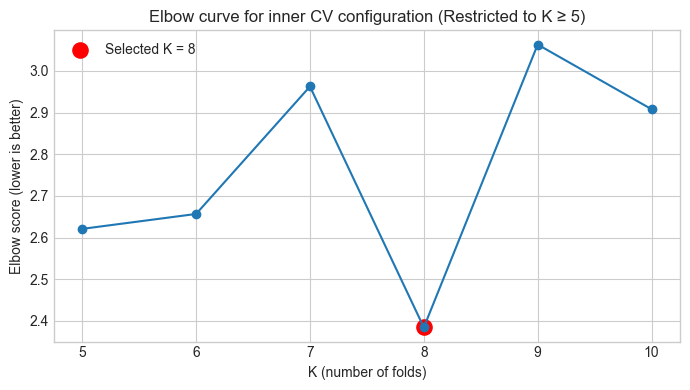

In [23]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(cv_elbow_restricted['K folds'], cv_elbow_restricted['ElbowScore'],
        marker='o', linestyle='-', color='tab:blue')

ax.set_xlabel('K (number of folds)')
ax.set_ylabel('Elbow score (lower is better)')
ax.set_title('Elbow curve for inner CV configuration (Restricted to K ≥ 5)')

ax.scatter(K_elbow,
           cv_elbow_restricted.loc[best_idx_elbow, 'ElbowScore'],
           color='red', s=120, label=f'Selected K = {K_elbow}')

ax.legend()
plt.tight_layout()
plt.show()

The inner evaluation results show that the mean cross-validation accuracy remains fairly stable across all values of $K$ between 3 and 10, with accuracies ranging approximately from 0.776 to 0.789. This indicates that increasing the number of folds provides only marginal improvements in the reliability of the performance estimate.

Execution time, however, increases steadily as $K$ grows. Small values such as $K = 3$ or $K = 4$ are computationally efficient, but they produce less stable estimates with higher variance, which is undesirable during hyperparameter optimisation. Larger values such as $K = 9$ or $K = 10$ offer slightly higher accuracy but at a substantially higher computational cost.

To evaluate the trade-off between accuracy, computational cost, and stability, all three metrics were normalised to $[0, 1]$, and an extended \textit{elbow score} was defined as:

$$
\text{ElbowScore} =
(1 - \text{Acc}_{\text{norm}})
+ \lambda_{\text{time}} \cdot \text{Time}_{\text{norm}}
+ \lambda_{\text{std}} \cdot \text{Std}_{\text{norm}},
$$

with $\lambda_{\text{time}} = 2$ giving additional importance to time, and
$\lambda_{\text{std}} = 1$ penalising configurations with high standard deviation.

Since very small $K$ values tend to produce unreliable performance estimates, the analysis was restricted to configurations with $K \ge 5$. Within this range, the elbow score identifies:

$$
\boxed{K = 8}
$$

as the configuration that best balances accuracy, computational cost, and stability. This setting achieves high mean accuracy, maintains low variability across folds, and avoids the excessive computation time required by $K = 9$ or $K = 10$.

$$
\boxed{K = 8\ \text{is selected as the inner cross-validation strategy}.}
$$

In [24]:
inner = StratifiedKFold(n_splits=8, shuffle=True, random_state=100473854)

##  <span style="color:#0066CC"> Basic Methods: KNN and Trees</span>

###  <span style="color:#0066CC"> Baseline Models: Training, Evaluation and Comparison</span>

First, we proceed to train a K-Nearest Neighbours (KNN) classifier on the training dataset, using the default hyperparameters provided by scikit-learn.

In [25]:
# Identify numerical and categorical columns on the TRAINING set
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Categorical preprocessing: imputation + encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Numerical preprocessing for KNN: StandardScaler (default for this test)
numeric_transformer = StandardScaler()

# Full preprocessing block
preprocessor_knn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# KNN model (default hyperparameters)
knn_clf = KNeighborsClassifier()

# Pipeline: preprocessing + model
knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_knn),
    ("clf", knn_clf)
])

# Compute inner CV performance using the selected inner splitter (K=7)
inner_scores_knn = cross_val_score(
    knn_pipeline,
    X_train,
    y_train,
    cv=inner,
    scoring="accuracy",
    n_jobs=-1
)

inner_mean_acc_knn = inner_scores_knn.mean()
inner_std_acc_knn = inner_scores_knn.std()

print(f"Inner CV accuracy (KNN, default hyperparameters): {inner_mean_acc_knn:.4f}")
print(f"Standard deviation across folds: {inner_std_acc_knn:.4f}")

Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_contacted']
Inner CV accuracy (KNN, default hyperparameters): 0.8103
Standard deviation across folds: 0.0092


Next, we train and evaluate a Decision Tree classification model, employing the default hyperparameters of scikit-learn as a baseline reference for subsequent comparisons.

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Identify numerical and categorical columns on the TRAINING set
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Preprocessing for Tree

# Numerical: passthrough (no scaling needed for trees)
numeric_transformer_tree = "passthrough"

# Categorical: same imputer + OneHotEncoder 
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Default Decision Tree classifier
tree_clf = DecisionTreeClassifier(
    random_state=100473854
)

# Full pipeline: preprocessing + model
tree_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_tree),
    ("clf", tree_clf)
])

# INNER EVALUATION: cross-validated accuracy on TRAINING data
inner_scores_tree = cross_val_score(
    tree_pipeline,
    X_train,
    y_train,
    cv=inner,
    scoring="accuracy",
    n_jobs=-1
)

inner_mean_acc_tree = inner_scores_tree.mean()
inner_std_acc_tree = inner_scores_tree.std()

print(f"Inner CV accuracy (Tree, default hyperparameters): {inner_mean_acc_tree:.4f}")
print(f"Standard deviation across folds: {inner_std_acc_tree:.4f}")

Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_contacted']
Inner CV accuracy (Tree, default hyperparameters): 0.7827
Standard deviation across folds: 0.0081


To establish a meaningful performance baseline, we now proceed to train and evaluate a Dummy Classifier on the training data. This model does not use any features; instead, it applies a simple rule (such as predicting the most frequent class) and therefore serves as a lower bound against which all subsequent models can be compared.


In [27]:
# Define Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Build a pipeline: preprocessing + dummy model
dummy_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_knn),    # reuse the same preprocessing as the other models
    ('model', dummy_clf)
])

# Perform inner cross-validated accuracy evaluation
dummy_scores = cross_val_score(
    dummy_pipeline,
    X_train,
    y_train,
    cv=inner,            # inner CV defined previously as StratifiedKFold(n_splits=7)
    scoring='accuracy',
    n_jobs=-1
)

# Compute mean and standard deviation
mean_dummy_acc = dummy_scores.mean()
std_dummy_acc = dummy_scores.std()

print(f"Dummy Classifier Accuracy (mean over folds): {mean_dummy_acc:.4f}")
print(f"Standard deviation across folds: {std_dummy_acc:.4f}")


Dummy Classifier Accuracy (mean over folds): 0.5255
Standard deviation across folds: 0.0003



We can extract the following conclusions:
- Both KNN and Decision Trees significantly outperform the dummy classifier, confirming that the dataset contains meaningful predictive structure.
- **KNN achieves the highest default performance**, making it initially the strongest of the two basic models.
- These baseline results justify proceeding to **hyper-parameter tuning (HPO)** for both models to determine whether further improvements can be achieved.

###  <span style="color:#0066CC"> Shallow Decision Tree for Interpretability</span>

To gain insight into the structure of the prediction problem, we trained a shallow
Decision Tree classifier with a restricted depth (`max_depth = 3`). Shallow trees offer
high interpretability, allowing us to inspect the most influential features and the main
decision rules learned from the data.

In [28]:
# First, we identify again numeric and categorical columns on the TRAINING set
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Preprocessing for the shallow decision tree: standard tabular setup
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),  # keep numeric as they are
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# Defining a shallow Decision Tree (low depth for interpretability)
shallow_tree = DecisionTreeClassifier(
    max_depth=3,             
    random_state=100473854
)

# Building the pipeline: preprocessing + model
shallow_tree_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_tree),
    ('model', shallow_tree)
])

# Fitting on training data
shallow_tree_pipeline.fit(X_train, y_train)
print("Shallow tree fitted successfully.")


Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Shallow tree fitted successfully.


To further enhance interpretability, we generate a graphical representation of the shallow
Decision Tree. This visualisation provides an intuitive overview of the model’s structure,
highlighting the sequence of decision rules, the thresholds applied at each split, and the 
distribution of classes within the terminal nodes. By inspecting the tree diagram, we can 
visually identify the most influential features and understand how the classifier partitions 
the feature space to distinguish between clients who subscribe to a term deposit and those who do not.

Number of features after encoding: 42


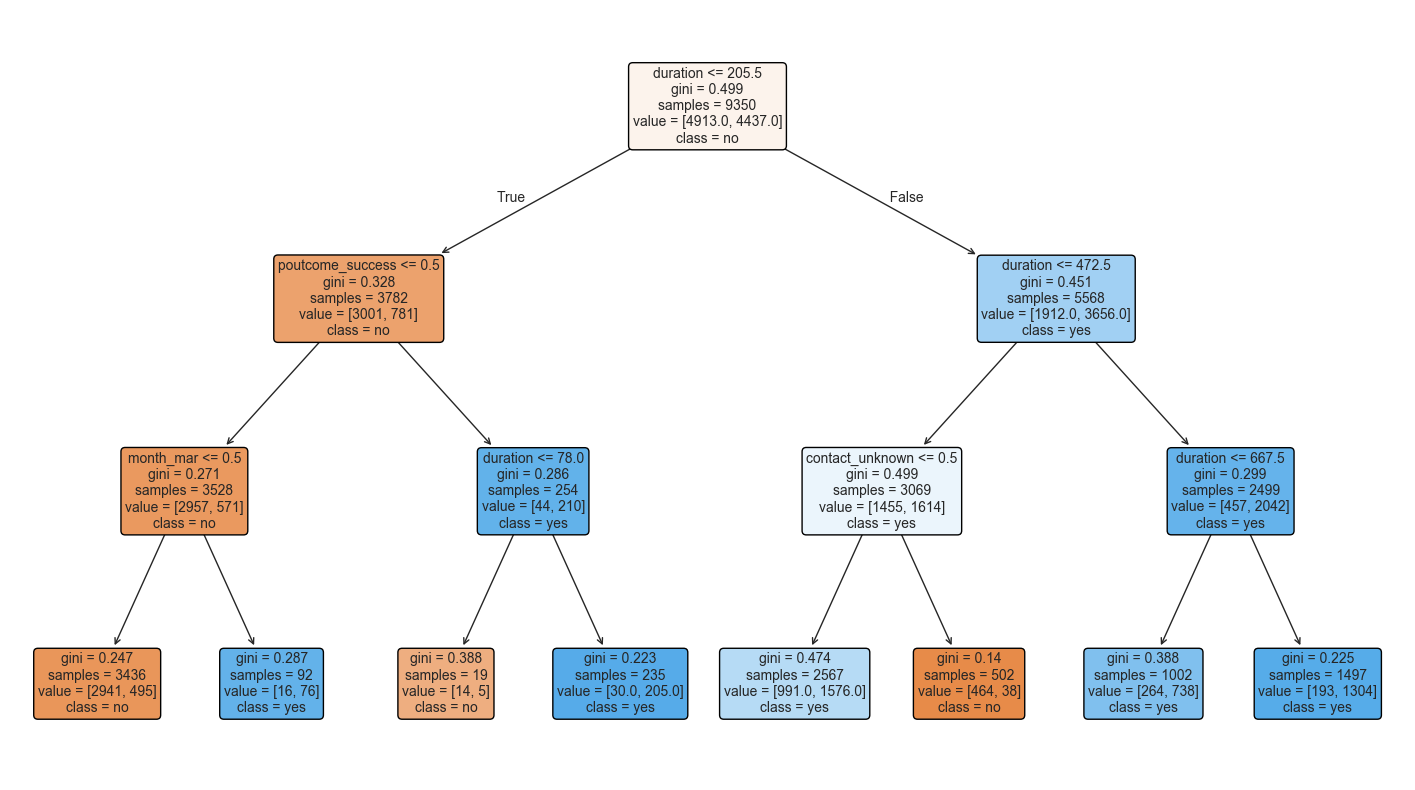

In [29]:
# Numeric feature names (passed through unchanged)
num_features = numeric_cols

# Categorical feature names after One-Hot Encoding
cat_encoder = shallow_tree_pipeline.named_steps['preprocess'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)

# Combine into a single list aligned with the transformed matrix
feature_names = list(num_features) + list(cat_features)
print("Number of features after encoding:", len(feature_names))

# Ploting the shallow decision tree

plt.figure(figsize=(18, 10))
plot_tree(
    shallow_tree_pipeline.named_steps['model'],
    feature_names=feature_names,
    class_names=['no', 'yes'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

**Note:** we set the maximum depth of the shallow Decision Tree to K = 3 in order to prioritise interpretability over predictive performance.

In addition to the visual inspection of the shallow Decision Tree, it is informative to 
quantify the contribution of each predictor to the model’s decisions. Feature importance 
analysis provides a numerical assessment of how much each variable reduces impurity across 
all splits where it is used. Higher values indicate that the feature plays a more decisive 
role in distinguishing between clients who subscribe to a term deposit and those who do not.

By examining the feature importance scores, we obtain a complementary perspective to the 
tree visualisation, allowing us to identify which attributes are systematically driving the 
predictions of the model. This analysis is particularly valuable in understanding the 
underlying structure of the problem and in guiding future modelling choices.

In [30]:
# Computing and inspect feature importances 

importances = shallow_tree_pipeline.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show the top features
importance_df.head(15)

,feature,importance
3,duration,0.687760
27,contact_unknown,0.141684
40,poutcome_success,0.122013
34,month_mar,0.048544
0,age,0.000000
31,month_jan,0.000000
24,housing_yes,0.000000
25,loan_yes,0.000000
26,contact_telephone,0.000000
28,month_aug,0.000000


The model consistently identifies **`duration`** as the dominant predictor, placing it at the root of the tree and using it repeatedly across several splits. This confirms that the duration of the last contact call is by far the most influential variable when predicting whether a client subscribes to a term deposit.

The next most relevant attributes according to the feature importance analysis are:

- **`contact_unknown`**, which captures cases in which the contact communication channel is unspecified. The model assigns this variable a substantial importance, indicating that an unknown contact method contains meaningful behavioural information, likely associated with unsuccessful or unregistered contact attempts.
- **`poutcome_success`**, referring to the outcome of a previous marketing campaign. A successful previous outcome strongly increases the probability that the client will subscribe again, which aligns with expected domain behaviour.
- **`month_mar`**, suggesting that temporal patterns in the campaign schedule may also influence subscription likelihood, albeit with considerably less impact than the top three predictors.

The remaining variables exhibit negligible importance in this shallow setting, which is coherent with the depth restriction: only the features that contribute most to reducing impurity within the first few levels appear in the tree.

Overall, the shallow tree provides an interpretable summary of the key drivers of the prediction problem: **call duration**, **contact status**, and **past campaign success**, with minor contributions from specific months. These insights help validate the main behavioural patterns in the dataset and offer a solid foundation before progressing to more complex and higher-capacity models.

##  <span style="color:#0066CC"> Hyperparameter Optimisation for KNN and Decision Trees</span>

To evaluate whether model performance can be improved beyond default configurations, we implement a unified framework for hyperparameter optimisation (HPO) applied to K-Nearest Neighbours and Decision Trees.

We define a consistent preprocessing pipeline that includes numerical scaling (Standard, Min-Max, or Robust scaling) and categorical treatment through imputation followed by one-hot encoding. The target variable is binarised to ensure full compatibility with optimisation routines.

Three complementary HPO strategies are explored:
- **Grid Search**, which exhaustively evaluates predefined parameter grids.
- **Random Search**, which samples parameter combinations from broader distributions.
- **Optuna**, a state-of-the-art optimisation library that adaptively explores the search space.

A generic experiment function is implemented to train any model–preprocessing–HPO combination, report the best cross-validated accuracy, and store results for later comparison.


In [ ]:
# --------------------------------------------------------------------------------------------------------
# Encode target for HPO (0/1 instead of 'no'/'yes')
# --------------------------------------------------------------------------------------------------------
y_train_bin = (y_train.str.strip().str.lower() == "yes").astype(int) # Just compute it to avoid errors
print("X_train rows:", X_train.shape[0])
print("y_train rows:", y_train.shape[0])

# --------------------------------------------------------------------------------------------------------
# Scorers and preprocessing objects
# --------------------------------------------------------------------------------------------------------
scoring = make_scorer(accuracy_score)

numeric_scalers = {
    "standard": StandardScaler(),
    "minmax": MinMaxScaler(),
    "robust": RobustScaler()
}

# Categorical preprocessing:
# 1) Impute missing values using most frequent category
# 2) Apply OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Dictionary to store results
results = {}

# --------------------------------------------------------------------------------------------------------
# Helper: build preprocessing + model pipeline
# --------------------------------------------------------------------------------------------------------
def make_pipeline(model_name: str, scaler_name: str):
    """
    model_name: 'knn' or 'tree'
    scaler_name: 'standard', 'minmax', or 'robust'
    """
    if scaler_name not in numeric_scalers:
        raise ValueError(f"Unknown scaler_name: {scaler_name}.")

    num_transformer = numeric_scalers[scaler_name]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols),
        ]
    )

    if model_name == "knn":
        model = KNeighborsClassifier()
    elif model_name == "tree":
        model = DecisionTreeClassifier(random_state=100473854)
    else:
        raise ValueError("Unknown model_name. Use 'knn' or 'tree'.")

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    return pipe

# --------------------------------------------------------------------------------------------------------
# HPO strategy: Grid Search
# --------------------------------------------------------------------------------------------------------
def run_grid_search(model_name, scaler_name):
    pipe = make_pipeline(model_name, scaler_name)

    if model_name == "knn":
        param_grid = {
            "model__n_neighbors": [3, 5, 7, 9],
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],
        }
    else:  # Decision Tree
        param_grid = {
            "model__max_depth": [3, 5, 7, None],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4],
            "model__max_features": [None, "sqrt", "log2"],
        }

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=inner,
        scoring=scoring,
        n_jobs=-1
    )
    gs.fit(X_train, y_train_bin)

    return gs.best_score_, gs.best_params_

# --------------------------------------------------------------------------------------------------------
# HPO strategy: Random Search
# --------------------------------------------------------------------------------------------------------
def run_random_search(model_name, scaler_name, n_iter=20):
    pipe = make_pipeline(model_name, scaler_name)

    if model_name == "knn":
        param_distributions = {
            "model__n_neighbors": np.arange(3, 31),
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],
        }
    else:  # Decision Tree
        param_distributions = {
            "model__max_depth": [None] + list(range(2, 15)),
            "model__min_samples_split": np.arange(2, 21),
            "model__min_samples_leaf": np.arange(1, 11),
            "model__max_features": [None, "sqrt", "log2"],
        }

    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=inner,
        scoring=scoring,
        n_jobs=-1,
        random_state=100473854,
    )
    rs.fit(X_train, y_train_bin)

    return rs.best_score_, rs.best_params_

# --------------------------------------------------------------------------------------------------------
# HPO strategy: Optuna
# --------------------------------------------------------------------------------------------------------
def run_optuna(model_name, scaler_name, n_trials=30):

    def objective(trial):
        pipe = make_pipeline(model_name, scaler_name)

        if model_name == "knn":
            params = {
                "model__n_neighbors": trial.suggest_int("n_neighbors", 3, 30),
                "model__p": trial.suggest_categorical("p", [1, 2]),
                "model__weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            }
        else:  # Decision Tree
            params = {
                "model__max_depth": trial.suggest_int("max_depth", 2, 20),
                "model__min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "model__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "model__max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
            }

        pipe.set_params(**params)

        scores = cross_val_score(
            pipe,
            X_train,
            y_train_bin,
            cv=inner,
            scoring="accuracy",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_score = study.best_value
    bp = study.best_params

    # Map parameter names to pipeline format
    if model_name == "knn":
        bp = {
            "model__n_neighbors": bp["n_neighbors"],
            "model__p": bp["p"],
            "model__weights": bp["weights"],
        }
    else:
        bp = {
            "model__max_depth": bp["max_depth"],
            "model__min_samples_split": bp["min_samples_split"],
            "model__min_samples_leaf": bp["min_samples_leaf"],
            "model__max_features": bp["max_features"],
        }

    return best_score, bp

from pprint import pprint

# --------------------------------------------------------------------------------------------------------
# Wrapper: run one experiment manually (pretty output)
# --------------------------------------------------------------------------------------------------------
def run_experiment(model_name, scaler_name, hpo_method,
                   n_iter_random=20, n_trials_optuna=30, store_results=True):

    header = f" Model: {model_name.upper()} | Scaler: {scaler_name} | HPO: {hpo_method} "
    print("\n" + "=" * len(header))
    print(header)
    print("=" * len(header))
    Start.time = time.perf_counter()

    if hpo_method == "grid":
        best_score, best_params = run_grid_search(model_name, scaler_name)

    elif hpo_method == "random":
        best_score, best_params = run_random_search(
            model_name, scaler_name, n_iter_random
        )

    elif hpo_method == "optuna":
        best_score, best_params = run_optuna(
            model_name, scaler_name, n_trials_optuna
        )

    else:
        raise ValueError("hpo_method must be 'grid', 'random', or 'optuna'.")

    print(f"\n→ Best CV accuracy: {best_score:.4f}")
    print("→ Best hyperparameters:")
    for k, v in best_params.items():
        print(f"   • {k}: {v}")

    if store_results:
        key = (model_name.upper(), scaler_name, hpo_method)
        results[key] = {
            "best_score": best_score,
            "best_params": best_params,
            "elapsed_time": elapsed
        }
    elapsed = time.perf_counter() - Start.time

    return best_score, best_params, elapsed

# --------------------------------------------------------------------------------------------------------
# Optional: show all experiments in a compact table
# --------------------------------------------------------------------------------------------------------
def show_all_results(results_dict=results):
    if not results_dict:
        print("No experiments stored yet.")
        return

    rows = []
    for (model, scaler, hpo), info in results_dict.items():
        rows.append({
            "Model": model,
            "Scaler": scaler,
            "HPO": hpo,
            "Best CV accuracy": round(info["best_score"], 4)
        })

    df_results = pd.DataFrame(rows).sort_values(
        by="Best CV accuracy", ascending=False
    ).reset_index(drop=True)

    print("\nSummary of stored experiments:")
    display(df_results)

X_train rows: 9350
y_train rows: 9350


We now proceed to train the KNN classifier using the Random Search hyperparameter optimisation strategy, evaluating its performance under each of the numerical preprocessing schemes (StandardScaler, MinMaxScaler, and RobustScaler).

In [32]:
# KNN + Standard Scaler + Random Search
run_experiment(model_name="knn", scaler_name="standard", hpo_method="random", n_iter_random=30);


 Model: KNN | Scaler: standard | HPO: random 

→ Best CV accuracy: 0.8227
→ Best hyperparameters:
   • model__weights: distance
   • model__p: 2
   • model__n_neighbors: 16


In [33]:
# KNN + MinMax Scaler + Random Search
run_experiment(model_name="knn", scaler_name="minmax", hpo_method="random", n_iter_random=100);


 Model: KNN | Scaler: minmax | HPO: random 

→ Best CV accuracy: 0.7441
→ Best hyperparameters:
   • model__weights: distance
   • model__p: 1
   • model__n_neighbors: 20


In [34]:
# KNN + Robust Scaler + Random Search
run_experiment(model_name="knn", scaler_name="robust", hpo_method="random", n_iter_random=30);


 Model: KNN | Scaler: robust | HPO: random 

→ Best CV accuracy: 0.8123
→ Best hyperparameters:
   • model__weights: distance
   • model__p: 2
   • model__n_neighbors: 15


We now continue by training the K-Nearest Neighbours (KNN) model using Optuna as the hyperparameter optimisation framework.

In [35]:
# KNN + Standard Scaler + Optuna
run_experiment(model_name="knn", scaler_name="standard", hpo_method="optuna", n_trials_optuna=50);

[I 2025-12-04 20:48:19,363] A new study created in memory with name: no-name-851fd17b-eaad-4db1-9905-c84d68f9ffea



 Model: KNN | Scaler: standard | HPO: optuna 


[I 2025-12-04 20:48:19,856] Trial 0 finished with value: 0.7992504167301404 and parameters: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}. Best is trial 0 with value: 0.7992504167301404.
[I 2025-12-04 20:48:20,467] Trial 1 finished with value: 0.8185006576865839 and parameters: {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}. Best is trial 1 with value: 0.8185006576865839.
[I 2025-12-04 20:48:21,027] Trial 2 finished with value: 0.7992504167301404 and parameters: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}. Best is trial 1 with value: 0.8185006576865839.
[I 2025-12-04 20:48:21,501] Trial 3 finished with value: 0.8194638426180907 and parameters: {'n_neighbors': 26, 'p': 2, 'weights': 'distance'}. Best is trial 3 with value: 0.8194638426180907.
[I 2025-12-04 20:48:22,152] Trial 4 finished with value: 0.8159343617071142 and parameters: {'n_neighbors': 24, 'p': 1, 'weights': 'distance'}. Best is trial 3 with value: 0.8194638426180907.
[I 2025-12-04 20:48:22,754] Trial 5 finish


→ Best CV accuracy: 0.8227
→ Best hyperparameters:
   • model__n_neighbors: 16
   • model__p: 2
   • model__weights: distance


In [36]:
# KNN + MinMax Scaler + Optuna
run_experiment(model_name="knn", scaler_name="minmax", hpo_method="optuna", n_trials_optuna=50);

[I 2025-12-04 20:48:44,759] A new study created in memory with name: no-name-ec3f34da-12b3-4e94-9397-7975f8c090b1



 Model: KNN | Scaler: minmax | HPO: optuna 


[I 2025-12-04 20:48:45,582] Trial 0 finished with value: 0.7266289644292628 and parameters: {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}. Best is trial 0 with value: 0.7266289644292628.
[I 2025-12-04 20:48:45,986] Trial 1 finished with value: 0.734651019633922 and parameters: {'n_neighbors': 19, 'p': 2, 'weights': 'distance'}. Best is trial 1 with value: 0.734651019633922.
[I 2025-12-04 20:48:46,709] Trial 2 finished with value: 0.738930102124518 and parameters: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}. Best is trial 2 with value: 0.738930102124518.
[I 2025-12-04 20:48:47,143] Trial 3 finished with value: 0.7333693364249974 and parameters: {'n_neighbors': 8, 'p': 2, 'weights': 'distance'}. Best is trial 2 with value: 0.738930102124518.
[I 2025-12-04 20:48:47,611] Trial 4 finished with value: 0.7325137213342396 and parameters: {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}. Best is trial 2 with value: 0.738930102124518.
[I 2025-12-04 20:48:48,159] Trial 5 finished with


→ Best CV accuracy: 0.7441
→ Best hyperparameters:
   • model__n_neighbors: 19
   • model__p: 1
   • model__weights: distance


In [40]:
# KNN + Robust Scaler + Optuna
run_experiment(model_name="knn", scaler_name="robust", hpo_method="optuna", n_trials_optuna=50);

[I 2025-12-04 20:51:43,326] A new study created in memory with name: no-name-98de512d-ed78-4fc0-915b-f5e924c82643



 Model: KNN | Scaler: robust | HPO: optuna 


[I 2025-12-04 20:51:44,061] Trial 0 finished with value: 0.801176328849151 and parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}. Best is trial 0 with value: 0.801176328849151.
[I 2025-12-04 20:51:44,592] Trial 1 finished with value: 0.8016044110409318 and parameters: {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'}. Best is trial 1 with value: 0.8016044110409318.
[I 2025-12-04 20:51:45,024] Trial 2 finished with value: 0.8101606534973107 and parameters: {'n_neighbors': 25, 'p': 2, 'weights': 'distance'}. Best is trial 2 with value: 0.8101606534973107.
[I 2025-12-04 20:51:45,724] Trial 3 finished with value: 0.8078062929913168 and parameters: {'n_neighbors': 24, 'p': 1, 'weights': 'distance'}. Best is trial 2 with value: 0.8101606534973107.
[I 2025-12-04 20:51:46,228] Trial 4 finished with value: 0.8048125556616708 and parameters: {'n_neighbors': 8, 'p': 2, 'weights': 'distance'}. Best is trial 2 with value: 0.8101606534973107.
[I 2025-12-04 20:51:46,578] Trial 5 finished 


→ Best CV accuracy: 0.8123
→ Best hyperparameters:
   • model__n_neighbors: 15
   • model__p: 2
   • model__weights: distance


Having evaluated the Decision Tree classifier with its default hyperparameters, we now proceed to optimise this model using several hyperparameter tuning strategies.

In [ ]:
# Decision Tree + Standard Scaler + Random Search
run_experiment(model_name="tree", scaler_name='standard',hpo_method="random", n_iter_random=50);


 Model: TREE | Scaler: standard | HPO: random 

→ Best CV accuracy: 0.8226
→ Best hyperparameters:
   • model__min_samples_split: 9
   • model__min_samples_leaf: 10
   • model__max_features: None
   • model__max_depth: 10


In [54]:
# Decision Tree + Standard Scaler + Optuna
run_experiment(model_name="tree", scaler_name='standard', hpo_method="optuna", n_trials_optuna=50);

[I 2025-12-04 21:04:57,605] A new study created in memory with name: no-name-22934024-a06e-415f-b32f-54f690f9ac19



 Model: TREE | Scaler: standard | HPO: optuna 


[I 2025-12-04 21:04:57,833] Trial 0 finished with value: 0.7859838053833624 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7859838053833624.
[I 2025-12-04 21:04:57,938] Trial 1 finished with value: 0.8078065676377187 and parameters: {'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 1 with value: 0.8078065676377187.
[I 2025-12-04 21:04:58,018] Trial 2 finished with value: 0.7667349376589288 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8078065676377187.
[I 2025-12-04 21:04:58,151] Trial 3 finished with value: 0.8202136272953116 and parameters: {'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 3 with value: 0.8202136272953116.
[I 2025-12-04 21:04:58,240] Trial 4 finished with value: 0.7778640676084231 and pa


→ Best CV accuracy: 0.8226
→ Best hyperparameters:
   • model__max_depth: 10
   • model__min_samples_split: 11
   • model__min_samples_leaf: 10
   • model__max_features: None


**Note**: Decision Trees do not require numerical feature scaling, because the algorithm is based on threshold-based splits rather than distance computations.Therefore, applying transformations such as Standardisation, Min-Max scaling, or Robust scaling does not affect the behaviour or performance of a Decision Tree classifier.

##  <span style="color:#0066CC"> Advanced Methods</span>

##  <span style="color:#0066CC"> Results and final model</span>

##  <span style="color:#0066CC"> Probability Calibration</span>

##  <span style="color:#0066CC"> Open Choice Task</span>